In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pycaret.classification import *

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from matplotlib.colors import ListedColormap


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pycaret.regression import *
from sklearn.metrics import silhouette_samples, silhouette_score
import math
import random
import matplotlib.ticker as mtick
import re
import plotly.express as px


from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error


from neighborhoods import madrid_districts_dict
# from pycaret.classification import *
import shap
shap.initjs()

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
admin_wards = []
district_neighborhoods = []

for key in madrid_districts_dict:
    admin_wards.extend(madrid_districts_dict[key])
    district_neighborhoods.extend(key)

In [4]:
random.seed(42)

In [5]:
# Load the dataset
df = pd.read_csv('../data/scraped_data_cleaned_Emanuela_22Jul24.csv')
df = df[df['m2']<150]

df_unseen = df.iloc[:1000]

df = df.drop(df_unseen.index)

df.head()

,price,has_orientation_south,has_orientation_north,has_orientation_west,has_orientation_east,rooms,bathrooms,has_terrace,m2,elevator,...,distance_city_center,distance_metro,distance_castellana,price_m2_Q1_2024,price_m2_Q2_2024,price_m2_Q4_2023,price_m2_Q3_2023,district_affordability,CAGR,airbnb_price_per_night
1294,"345,000.00",1.00,0.00,0.00,0.00,1,1.00,0.00,64.00,1,...,NaN,NaN,NaN,3900,3993,3938,3892,45.50,4.80,100.12
1295,"1,215,000.00",0.00,0.00,0.00,1.00,2,2.00,0.00,81.00,1,...,NaN,NaN,NaN,5955,6062,5898,5800,48.40,5.90,265.81
1296,"294,900.00",0.00,0.00,0.00,0.00,3,2.00,1.00,85.00,1,...,NaN,NaN,NaN,2736,2752,2719,2673,47.70,4.00,219.00
1304,"899,000.00",0.00,0.00,0.00,1.00,5,1.00,0.00,144.00,1,...,NaN,NaN,NaN,4988,5084,4999,4974,68.80,4.30,NaN
1309,"148,000.00",0.00,0.00,0.00,0.00,2,1.00,1.00,64.00,1,...,NaN,NaN,NaN,2104,2147,2083,2065,48.90,5.00,"3,595.67"


In [6]:
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [7]:
df = drop_outliers_iqr(df, 'price')

In [8]:
# df['price'] = df['price'].apply(lambda x: np.log(x))

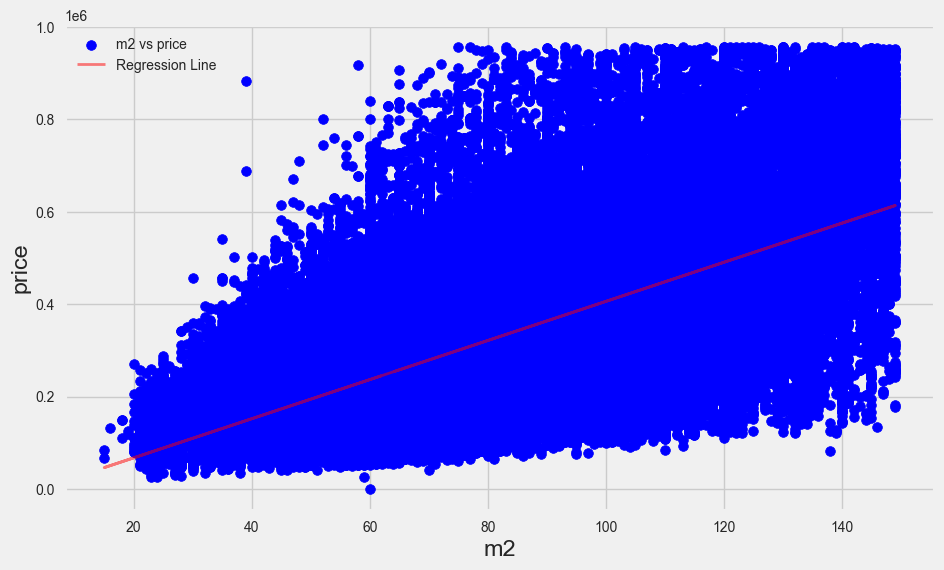

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(df['m2'], df['price'], color='blue', label='m2 vs price')

# Fit a linear regression line
m, b = np.polyfit(df['m2'], df['price'], 1)
plt.plot(df['m2'], m*df['m2'] + b, color='red', linewidth=2, alpha=0.5, label='Regression Line')

# Set labels and title
plt.xlabel('m2')
plt.ylabel('price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

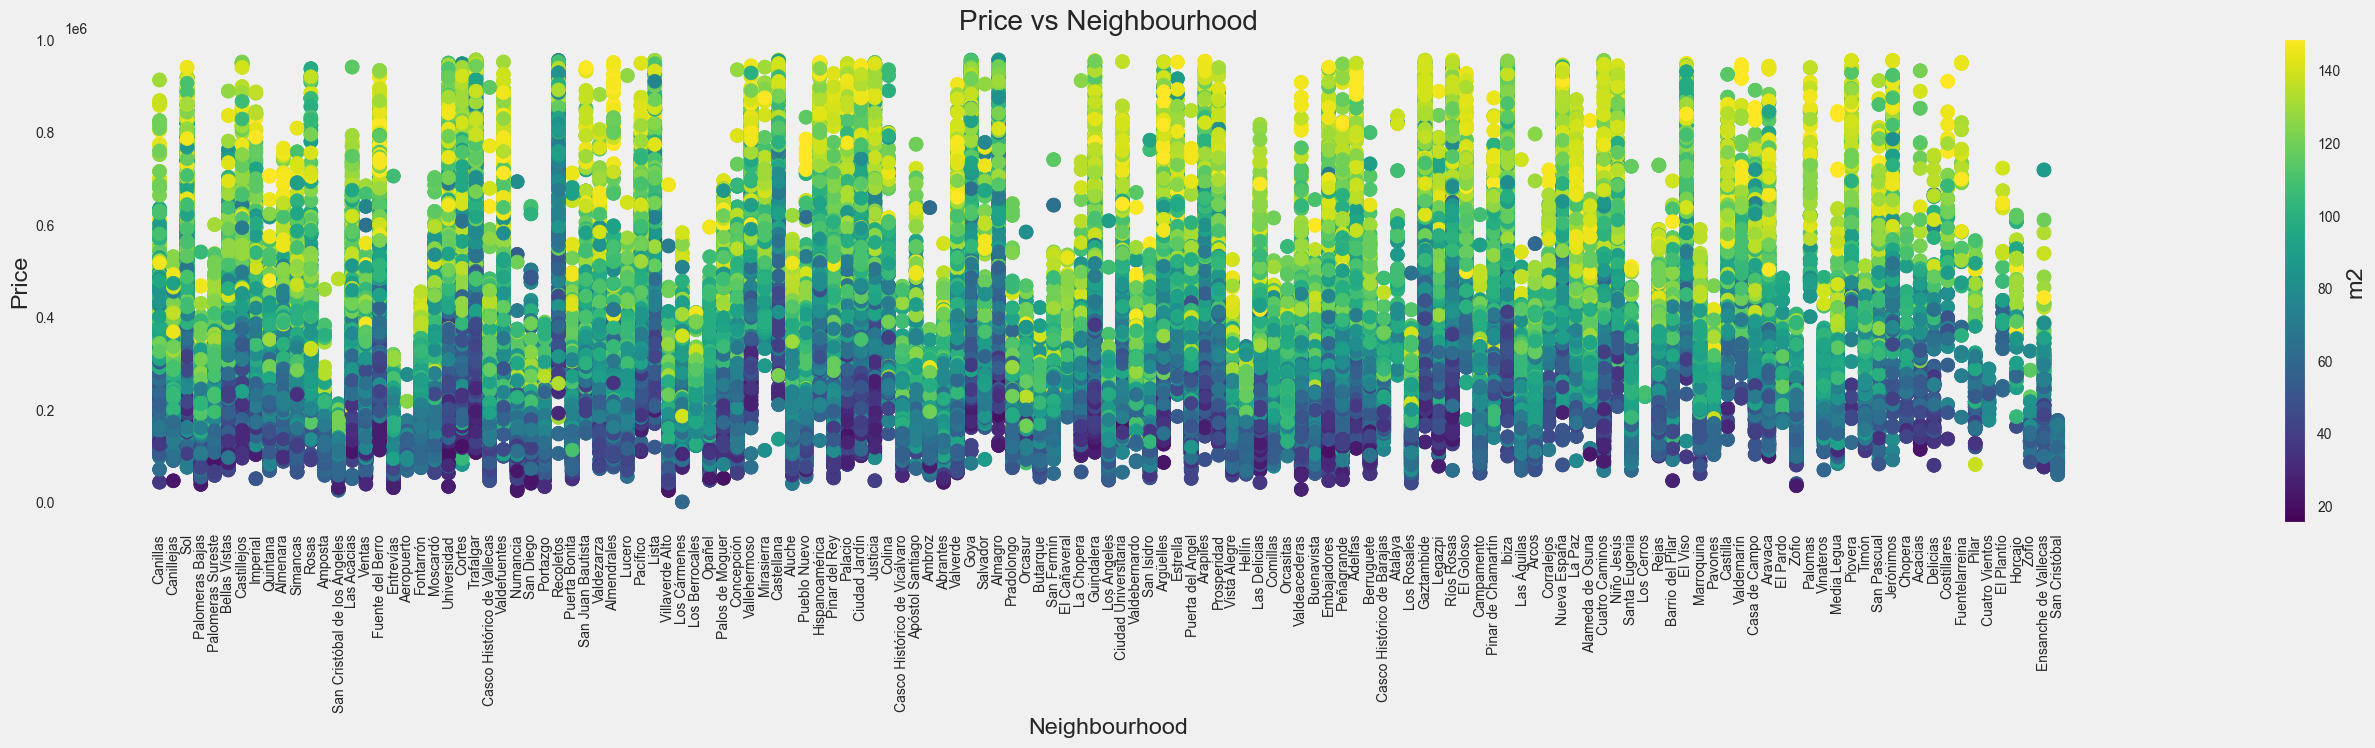

In [10]:
plt.figure(figsize=(30, 6))
plt.scatter(df['neighbourhood'], df['price'], c=df['m2'], cmap='viridis', s=100)
sc = plt.scatter(df['neighbourhood'], df['price'], c=df['m2'], cmap='viridis', s=100)
plt.colorbar(sc, label='m2')
plt.title('Price vs Neighbourhood')
plt.xticks(rotation=90)
plt.xlabel('Neighbourhood')
plt.ylabel('Price')

plt.grid(False)
plt.show()

In [11]:
df.describe()

,price,has_orientation_south,has_orientation_north,has_orientation_west,has_orientation_east,rooms,bathrooms,has_terrace,m2,elevator,...,distance_city_center,distance_metro,distance_castellana,price_m2_Q1_2024,price_m2_Q2_2024,price_m2_Q4_2023,price_m2_Q3_2023,district_affordability,CAGR,airbnb_price_per_night
count,"105,878.00","95,486.00","95,486.00","95,486.00","95,486.00","105,878.00","95,479.00","95,486.00","105,878.00","105,878.00",...,"78,217.00","78,217.00","78,217.00","105,878.00","105,878.00","105,878.00","105,878.00","105,878.00","105,878.00","81,116.00"
mean,"321,882.25",0.22,0.10,0.13,0.20,2.35,1.36,0.33,80.16,0.67,...,4.62,0.47,2.85,"3,703.18","3,767.66","3,674.77","3,629.52",52.72,5.04,170.28
std,"188,516.25",0.41,0.31,0.34,0.40,1.00,0.52,0.47,27.83,0.47,...,2.66,0.53,2.21,"1,233.69","1,257.29","1,232.11","1,215.08",8.43,0.63,235.42
min,819.98,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,0.00,...,0.02,0.00,0.00,"2,035.00","2,081.00","2,003.00","1,980.00",31.60,3.60,36.00
25%,"177,017.25",0.00,0.00,0.00,0.00,2.00,1.00,0.00,60.00,0.00,...,2.57,0.22,1.16,"2,544.00","2,570.00","2,493.00","2,468.00",47.90,4.60,106.71
50%,"265,421.00",0.00,0.00,0.00,0.00,2.00,1.00,0.00,76.00,1.00,...,4.32,0.34,2.17,"3,900.00","3,966.00","3,882.00","3,823.00",50.50,5.00,130.56
75%,"425,100.00",0.00,0.00,0.00,0.00,3.00,2.00,1.00,100.00,1.00,...,6.36,0.53,4.08,"4,988.00","5,084.00","4,999.00","4,951.00",58.80,5.50,165.97
max,"956,340.00",1.00,1.00,1.00,1.00,93.00,7.00,1.00,149.00,1.00,...,14.16,8.86,12.58,"5,955.00","6,062.00","5,898.00","5,800.00",68.80,6.40,"3,595.67"


In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [14]:
df_corr = pd.DataFrame(df[numerical_features].corr()['price'])
df_corr['price'] = df_corr['price'].apply(lambda x: abs(x))
df_corr.sort_values(by='price', ascending=False)

#openstreet map

,price
price,1.00
m2,0.62
price_m2_Q1_2024,0.59
price_m2_Q2_2024,0.59
price_m2_Q4_2023,0.59
price_m2_Q3_2023,0.59
bathrooms,0.55
elevator,0.44
distance_castellana,0.31
garage,0.23


In [15]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [16]:
# Define features and target variable
X = df[[column for column in df.columns if column != 'price']]
y = df['price']

In [17]:
# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [18]:
# Setup the environment in PyCaret
regression_setup = setup(
    data=df,
    target = 'price',
    ignore_features=[],
    numeric_imputation = 0,
    categorical_imputation = 'mode',
    transformation= True,
    transformation_method = 'yeo-johnson',
    normalize = True,
    normalize_method = 'zscore',
    session_id=42,
)

,Description,Value
0,Session id,42
1,Target,price
2,Target type,Regression
3,Original data shape,"(105878, 26)"
4,Transformed data shape,"(105878, 46)"
5,Transformed train set shape,"(74114, 46)"
6,Transformed test set shape,"(31764, 46)"
7,Numeric features,23
8,Categorical features,2
9,Rows with missing values,37.2%


In [19]:
n_iter=50

# print('Tune Model:')
# best_model = tune_model(best_model, n_iter=n_iter, choose_better=True)

# print('Tune Model - optuna:')
# best_model = tune_model(best_model, search_library = 'optuna', n_iter=n_iter, choose_better=True)

# print('Tune Model - scikit-optimize:')
# best_model = tune_model(best_model, search_library = 'scikit-optimize', n_iter=n_iter, choose_better=True)

# print('Bagging:')
# best_model = ensemble_model(best_model, method = 'Bagging', choose_better=True)

# print('Boosting:')
# best_model = ensemble_model(best_model, method = 'Boosting', choose_better=True)

print('Top 3 Models:')
best_mae_models_top3 = compare_models(sort = 'MAPE', n_select = 3, exclude=['lar', 'lr'])

print('Blending:')
best_model = blend_models(best_mae_models_top3, choose_better=True)

# print('Stacking:')
# best_model = stack_models(best_mae_models_top3, choose_better=True)

Top 3 Models:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,36890.4060,3544041781.8037,59527.4802,0.8999,0.1855,0.1329,4.1630
rf,Random Forest Regressor,38412.2611,3603031001.6779,60017.0325,0.8982,0.1859,0.1384,5.2890
catboost,CatBoost Regressor,43158.2132,3997149538.5136,63219.4863,0.8871,0.1973,0.1549,1.3560
xgboost,Extreme Gradient Boosting,43331.1945,4033532748.8000,63506.1891,0.8861,0.1983,0.1556,0.2990
lightgbm,Light Gradient Boosting Machine,45505.4225,4385176423.6345,66216.8366,0.8761,0.2064,0.1634,0.9100
dt,Decision Tree Regressor,50414.2043,6782695556.0266,82332.3802,0.8083,0.2515,0.1776,0.3370
gbr,Gradient Boosting Regressor,50281.1206,5243162232.5478,72404.7864,0.8519,0.2224,0.1796,1.7800
knn,K Neighbors Regressor,52943.7363,6139430092.8000,78345.1023,0.8266,0.2322,0.1834,0.7470
par,Passive Aggressive Regressor,60931.7583,7407662604.2914,86062.5289,0.7908,0.3500,0.2233,0.2920
huber,Huber Regressor,60974.2553,7298531553.8778,85426.6121,0.7939,0.3653,0.2266,0.2710


Blending:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,38276.7602,3558427484.6633,59652.5564,0.8988,0.1834,0.1347
1,36874.7910,3196617706.5047,56538.6391,0.9123,0.1757,0.1292
2,37511.8774,3298249891.0467,57430.3917,0.9065,0.1764,0.1308
3,37301.5306,3299729555.0954,57443.2725,0.9085,0.1798,0.1315
4,37471.9480,3359560007.4939,57961.7116,0.9046,0.1806,0.1325
5,37780.8578,3372753625.2796,58075.4133,0.9059,0.1885,0.1612
6,38003.3115,3427489390.2364,58544.7640,0.9015,0.1827,0.1354
7,37501.7374,3371986759.2861,58068.8106,0.9042,0.1808,0.1330
8,38007.7774,3373799730.8162,58084.4190,0.9024,0.1831,0.1363


In [20]:
save_model(best_model, model_name = 'deployment_26072024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['has_orientation_south',
                                              'has_orientation_north',
                                              'has_orientation_west',
                                              'has_orientation_east', 'rooms',
                                              'bathrooms', 'has_terrace', 'm2',
                                              'elevator', 'garage', 'built_year',
                                              'has_pool', 'has_ac',
                                              'distance_city_center',
                                              'distance_metro',
                                              'distance_castellana',
                                              'price_m...
                  TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                 ('normalize', TransformerWrapper(t

In [21]:
holdout_pred = predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,38012.1274,3455394861.8410,58782.6068,0.9035,0.1826,0.1342


In [22]:
RMSE = np.sqrt(mean_squared_error(holdout_pred['price'], holdout_pred['prediction_label']))
RMSE/(holdout_pred['price'].max() - holdout_pred['price'].min())

0.06347054095160314

In [23]:
holdout_pred['pred_diff'] = holdout_pred['prediction_label'] - holdout_pred['price']
holdout_pred['abs_pred_diff'] = holdout_pred['pred_diff'].apply(lambda x: abs(x))
holdout_pred['abs_pred_%'] = holdout_pred['abs_pred_diff']/holdout_pred['price']

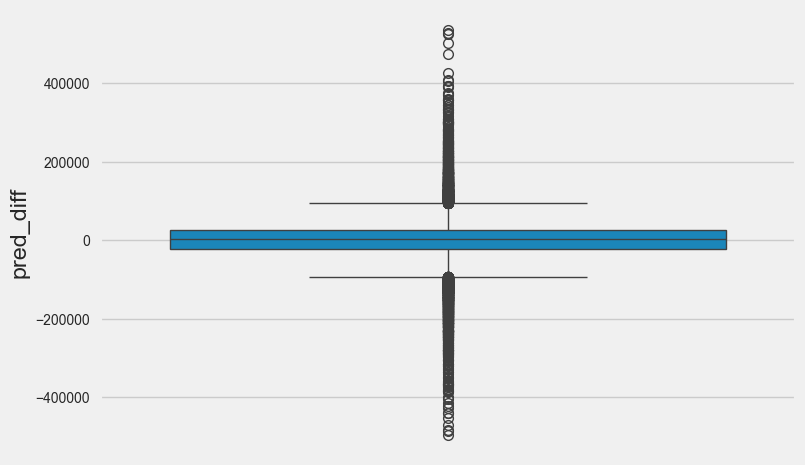

In [24]:
sns.boxplot(holdout_pred['pred_diff'])
plt.show()

In [25]:
import matplotlib.ticker as mticker

In [26]:
# le = LabelEncoder()
# holdout_pred['district_encoded'] = le.fit_transform(holdout_pred['built_year'])

# plt.figure(figsize=(10, 6))
# plt.scatter(holdout_pred['m2'], holdout_pred['abs_pred_%'], c=holdout_pred['m2'], alpha=0.3, cmap='viridis', s=100)
# sc = plt.scatter(holdout_pred['m2'], holdout_pred['abs_pred_%'], c=holdout_pred['m2'], alpha=0.3, cmap='viridis', s=100)
# plt.colorbar(sc, label='')
# plt.title('')
# # plt.xticks(rotation=90)
# plt.xlabel('m2', labelpad=15)
# plt.ylabel('Absolute Percentage Error', labelpad=15)

# plt.grid(False)
# plt.show()

In [27]:
num_features_plot = ['price', 'm2']

In [28]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

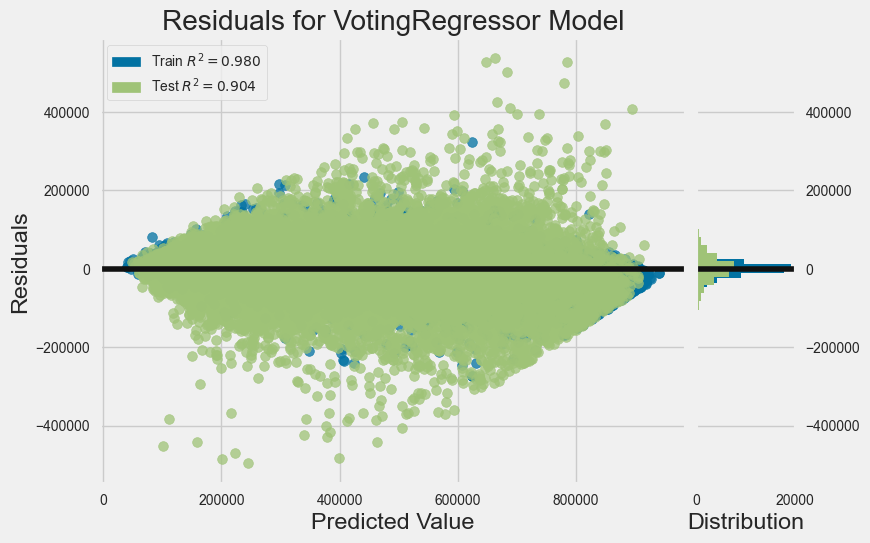

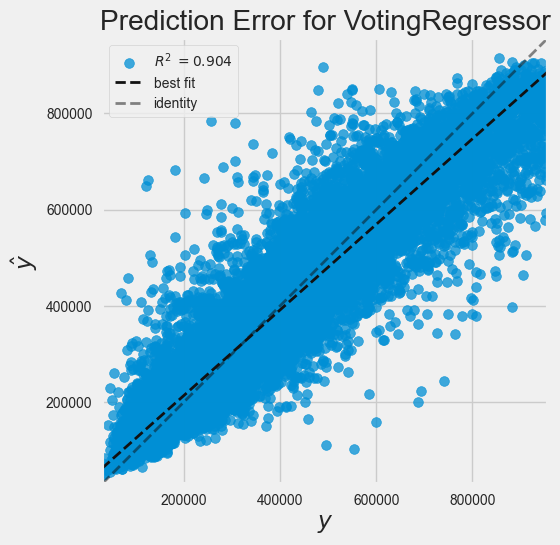

In [29]:
plot_model(best_model, plot = 'residuals', fold=10)

plot_model(best_model, plot = 'error')

# plot_model(best_model, plot = 'feature')

# plot_model(best_model, plot = 'learning')

<Axes: >

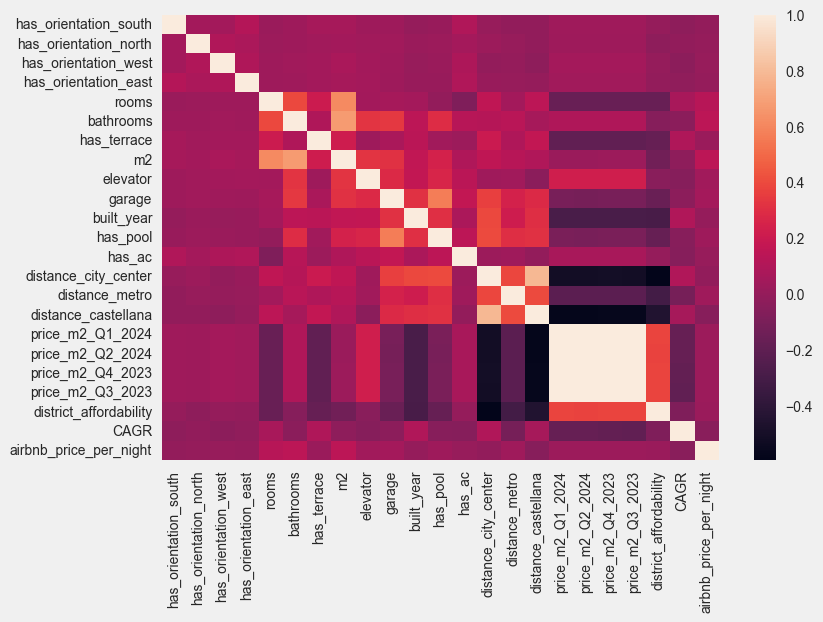

In [30]:
sns.heatmap(df[numerical_features].corr())